In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import random


In [2]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image




In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [4]:
root_dir = "/home/ct_wsuser/data/superresolution/comics"


dataset = ImageDataset(root_dir=root_dir, transform=transform)

In [5]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

Train size: 6538, Validation size: 817, Test size: 818


In [6]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [7]:
num_train_images = len(train_dataset)
num_val_images = len(val_dataset)
num_test_images = len(test_dataset)

print(f"Number of images in Training set: {num_train_images}")
print(f"Number of images in Validation set: {num_val_images}")
print(f"Number of images in Test set: {num_test_images}")

Number of images in Training set: 6538
Number of images in Validation set: 817
Number of images in Test set: 818


In [8]:
num_train_batches = len(train_loader)
num_val_batches = len(val_loader)
num_test_batches = len(test_loader)

print(f"Number of batches in Training set: {num_train_batches}") 
print(f"Number of batches in Validation set: {num_val_batches}")
print(f"Number of batches in Test set: {num_test_batches}")

Number of batches in Training set: 409
Number of batches in Validation set: 52
Number of batches in Test set: 52


In [9]:
class SRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)        
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
        self.dropout = nn.Dropout(p=0.5)  

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = F.relu(x1)
        x2 = self.conv2(x1)
        x2 = F.relu(x2)
        x2 = self.dropout(x2)
        output = self.conv3(x2)
        output += x 
        return output

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

cuda


In [11]:
def calculate_metrics(output, target):
    output_np = output.permute(0, 2, 3, 1).cpu().numpy()
    target_np = target.permute(0, 2, 3, 1).cpu().numpy()
    ssim_val = np.mean([ssim(o, t, data_range=t.max() - t.min(), channel_axis=-1, win_size=5) for o, t in zip(output_np, target_np)])
    psnr_val = np.mean([psnr(t, o, data_range=t.max() - t.min()) for o, t in zip(output_np, target_np)])
    mse_val = np.mean((output_np - target_np) ** 2)
    return ssim_val, psnr_val, mse_val

In [12]:
def visualize_images(original, upsampled, output):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original.cpu().permute(1, 2, 0).numpy())
    plt.title('GROUND TRUTH')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(upsampled.cpu().permute(1, 2, 0).numpy())
    plt.title('UPSAMPLED IMAGE')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(output.cpu().permute(1, 2, 0).numpy())
    plt.title('SRCNN OUTPUT')
    plt.axis('off')
    
    plt.show()

Epoch [1/70], Step [10/409], Loss: 0.0027
Epoch [1/70], Step [20/409], Loss: 0.0022
Epoch [1/70], Step [30/409], Loss: 0.0019
Epoch [1/70], Step [40/409], Loss: 0.0018
Epoch [1/70], Step [50/409], Loss: 0.0018
Epoch [1/70], Step [60/409], Loss: 0.0020
Epoch [1/70], Step [70/409], Loss: 0.0018
Epoch [1/70], Step [80/409], Loss: 0.0017
Epoch [1/70], Step [90/409], Loss: 0.0018
Epoch [1/70], Step [100/409], Loss: 0.0019
Epoch [1/70], Step [110/409], Loss: 0.0016
Epoch [1/70], Step [120/409], Loss: 0.0017
Epoch [1/70], Step [130/409], Loss: 0.0017
Epoch [1/70], Step [140/409], Loss: 0.0015
Epoch [1/70], Step [150/409], Loss: 0.0017
Epoch [1/70], Step [160/409], Loss: 0.0016
Epoch [1/70], Step [170/409], Loss: 0.0015
Epoch [1/70], Step [180/409], Loss: 0.0013
Epoch [1/70], Step [190/409], Loss: 0.0015
Epoch [1/70], Step [200/409], Loss: 0.0017
Epoch [1/70], Step [210/409], Loss: 0.0015
Epoch [1/70], Step [220/409], Loss: 0.0017
Epoch [1/70], Step [230/409], Loss: 0.0014
Epoch [1/70], Step [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.01944691..0.96240664].


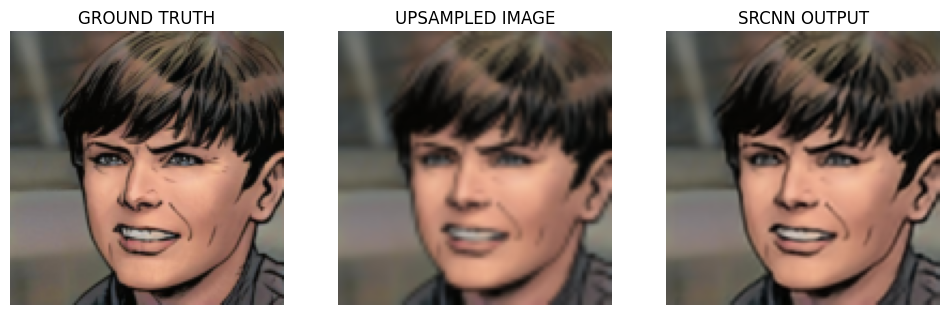

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0155654885..1.0128686].


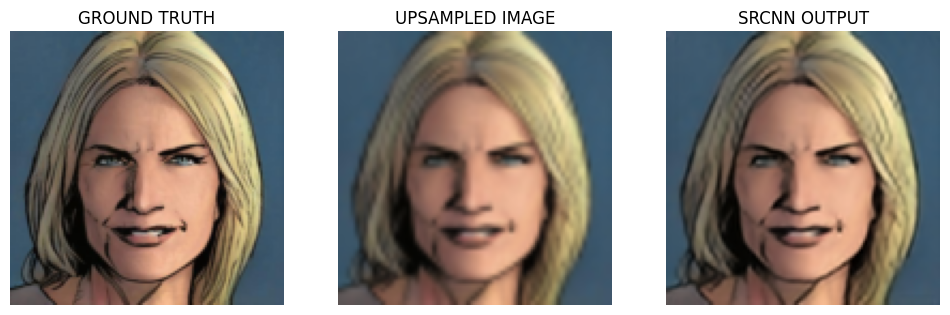

Validation - Epoch [10/70], SSIM: 0.9182, PSNR: 30.1462, MSE: 0.0009
Epoch [11/70], Step [10/409], Loss: 0.0013
Epoch [11/70], Step [20/409], Loss: 0.0013
Epoch [11/70], Step [30/409], Loss: 0.0010
Epoch [11/70], Step [40/409], Loss: 0.0011
Epoch [11/70], Step [50/409], Loss: 0.0012
Epoch [11/70], Step [60/409], Loss: 0.0012
Epoch [11/70], Step [70/409], Loss: 0.0012
Epoch [11/70], Step [80/409], Loss: 0.0014
Epoch [11/70], Step [90/409], Loss: 0.0011
Epoch [11/70], Step [100/409], Loss: 0.0013
Epoch [11/70], Step [110/409], Loss: 0.0011
Epoch [11/70], Step [120/409], Loss: 0.0011
Epoch [11/70], Step [130/409], Loss: 0.0009
Epoch [11/70], Step [140/409], Loss: 0.0011
Epoch [11/70], Step [150/409], Loss: 0.0012
Epoch [11/70], Step [160/409], Loss: 0.0012
Epoch [11/70], Step [170/409], Loss: 0.0011
Epoch [11/70], Step [180/409], Loss: 0.0012
Epoch [11/70], Step [190/409], Loss: 0.0011
Epoch [11/70], Step [200/409], Loss: 0.0011
Epoch [11/70], Step [210/409], Loss: 0.0011
Epoch [11/70], S

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.025505766..1.0334038].


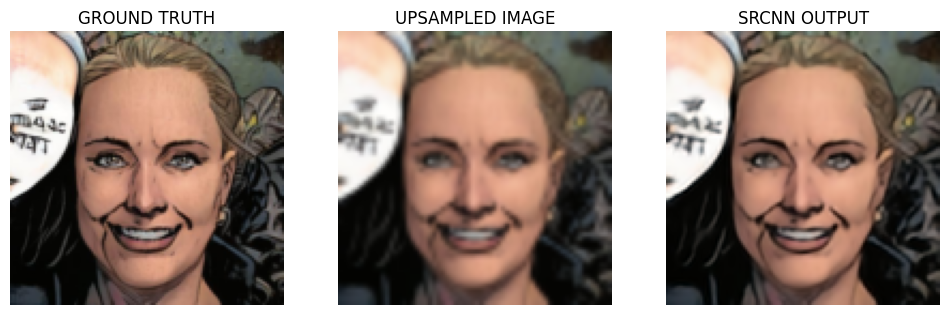

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011462849..1.0377668].


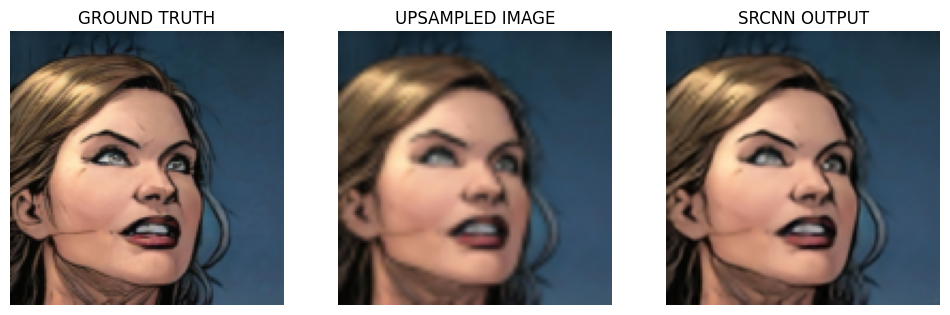

Validation - Epoch [20/70], SSIM: 0.9291, PSNR: 30.2388, MSE: 0.0010
Epoch [21/70], Step [10/409], Loss: 0.0009
Epoch [21/70], Step [20/409], Loss: 0.0012
Epoch [21/70], Step [30/409], Loss: 0.0012
Epoch [21/70], Step [40/409], Loss: 0.0010
Epoch [21/70], Step [50/409], Loss: 0.0010
Epoch [21/70], Step [60/409], Loss: 0.0011
Epoch [21/70], Step [70/409], Loss: 0.0010
Epoch [21/70], Step [80/409], Loss: 0.0010
Epoch [21/70], Step [90/409], Loss: 0.0011
Epoch [21/70], Step [100/409], Loss: 0.0012
Epoch [21/70], Step [110/409], Loss: 0.0009
Epoch [21/70], Step [120/409], Loss: 0.0010
Epoch [21/70], Step [130/409], Loss: 0.0010
Epoch [21/70], Step [140/409], Loss: 0.0011
Epoch [21/70], Step [150/409], Loss: 0.0012
Epoch [21/70], Step [160/409], Loss: 0.0009
Epoch [21/70], Step [170/409], Loss: 0.0011
Epoch [21/70], Step [180/409], Loss: 0.0013
Epoch [21/70], Step [190/409], Loss: 0.0012
Epoch [21/70], Step [200/409], Loss: 0.0012
Epoch [21/70], Step [210/409], Loss: 0.0009
Epoch [21/70], S

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009194352..0.8908011].


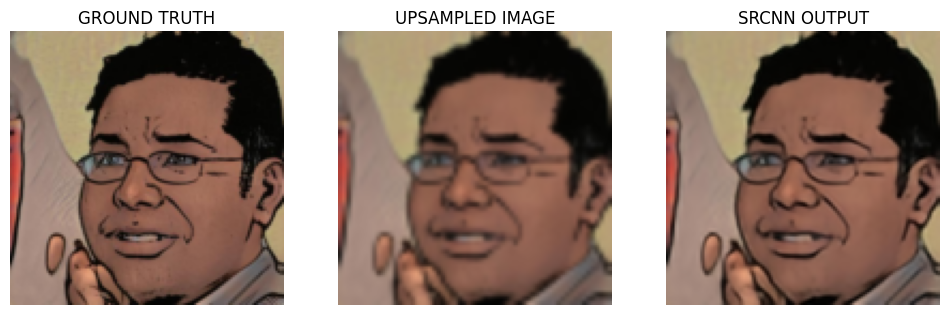

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0088217..1.0207967].


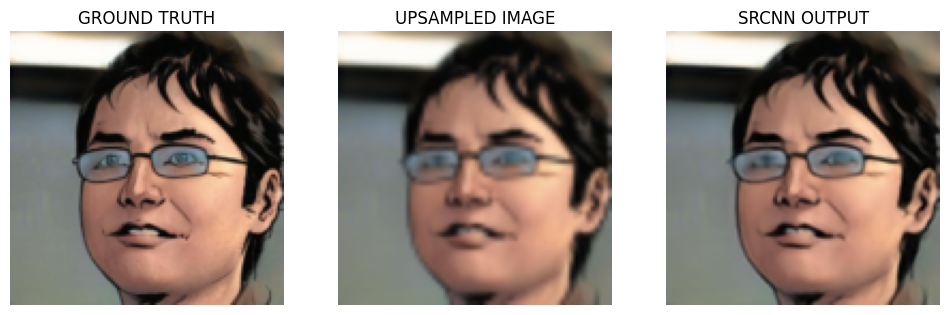

Validation - Epoch [30/70], SSIM: 0.9550, PSNR: 32.0926, MSE: 0.0005
Epoch [31/70], Step [10/409], Loss: 0.0010
Epoch [31/70], Step [20/409], Loss: 0.0011
Epoch [31/70], Step [30/409], Loss: 0.0011
Epoch [31/70], Step [40/409], Loss: 0.0010


In [ ]:
num_epochs = 70
scale_factor = 0.5

for epoch in range(num_epochs):
    model.train()
    for i, data in enumerate(train_loader):
        inputs = data.to(device)
        inputs_downsampled = F.interpolate(inputs, scale_factor=scale_factor, mode='bilinear', align_corners=False)
        inputs_upsampled = F.interpolate(inputs_downsampled, size=inputs.shape[2:], mode='bilinear', align_corners=False)
        #inputs_upsampled = F.interpolate(inputs, scale_factor=scale_factor, mode='bicubic', align_corners=False)
        outputs = model(inputs_upsampled)
        outputs = F.interpolate(outputs, size=inputs.shape[2:], mode='bicubic', align_corners=False)# Resize the output to match the input size
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    model.eval()
    ssim_total, psnr_total, mse_total = 0, 0, 0
    selected_images = random.sample(range(len(val_loader.dataset)), k=2) 
    
    with torch.no_grad():
        for idx in selected_images:
            inputs = val_loader.dataset[idx].unsqueeze(0).to(device) 
            inputs_downsampled = F.interpolate(inputs, scale_factor=scale_factor, mode='bilinear', align_corners=False)
            inputs_upsampled = F.interpolate(inputs_downsampled, size=inputs.shape[2:], mode='bilinear', align_corners=False)
            outputs = model(inputs_upsampled)
            outputs = F.interpolate(outputs, size=inputs.shape[2:], mode='bicubic', align_corners=False)
            ssim_val, psnr_val, mse_val = calculate_metrics(outputs, inputs)
            ssim_total += ssim_val
            psnr_total += psnr_val
            mse_total += mse_val
            
            if (epoch + 1) % 10 == 0:  
                
                visualize_images(inputs[0], inputs_upsampled[0], outputs[0])

    print(f'Validation - Epoch [{epoch + 1}/{num_epochs}], SSIM: {ssim_total / len(selected_images):.4f}, PSNR: {psnr_total / len(selected_images):.4f}, MSE: {mse_total / len(selected_images):.4f}')

In [14]:
torch.save(model.state_dict(), r"C:\Users\USER\Convolution\Task A")

RuntimeError: Parent directory C:\Users\USER\Convolution does not exist.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.40184993..1.3132343].


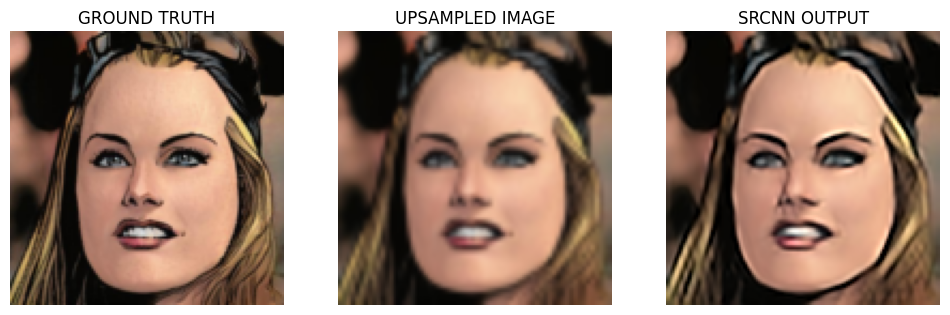

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.25485978..1.0193789].


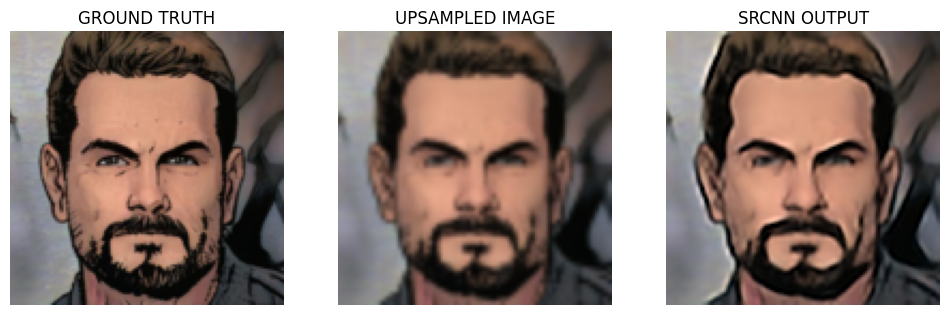

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38328326..1.0826898].


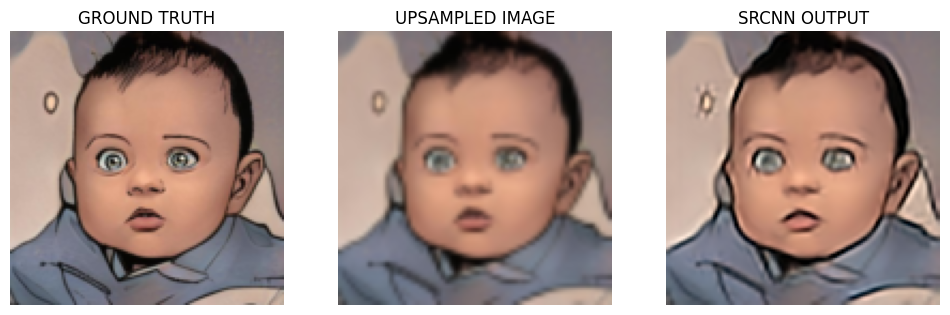

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.23396134..1.2078074].


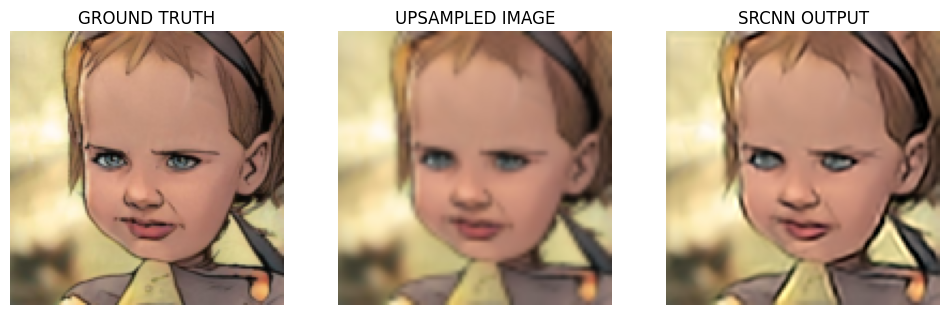

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34453347..1.1974818].


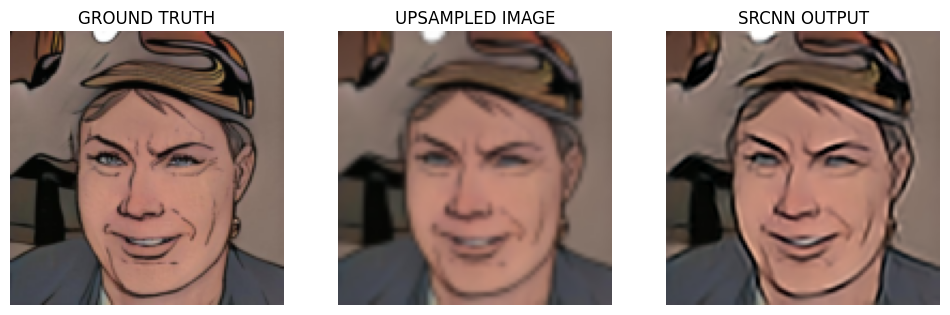

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3106102..1.1527787].


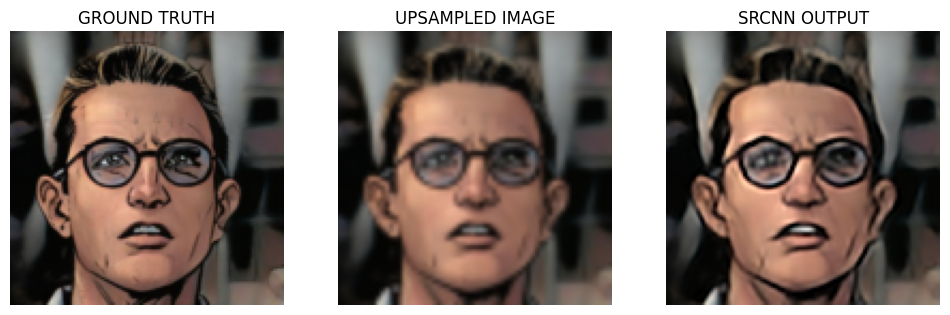

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2757415..1.2006468].


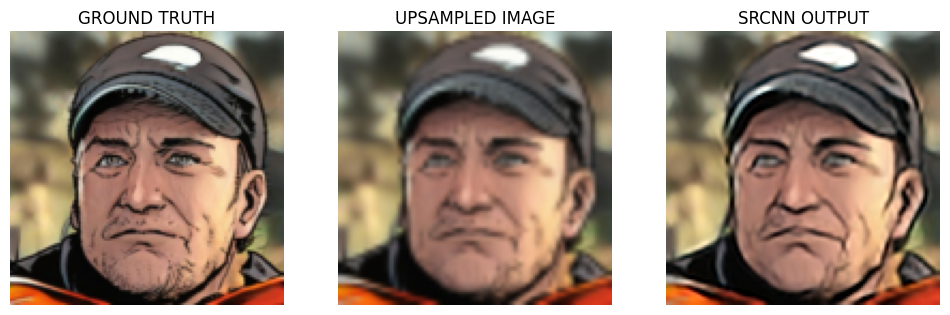

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19620138..1.0199019].


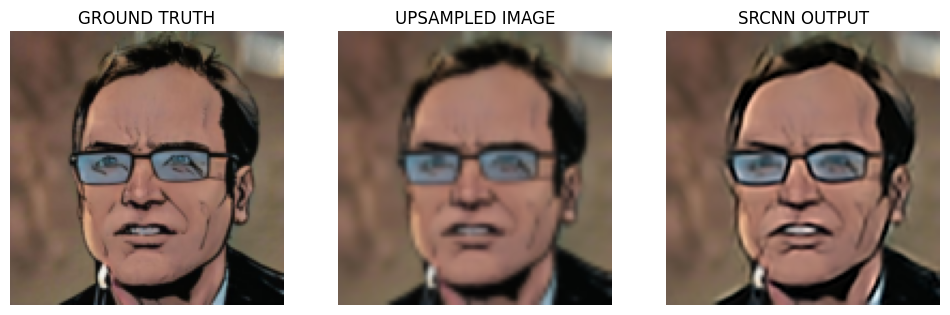

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34746727..1.0414786].


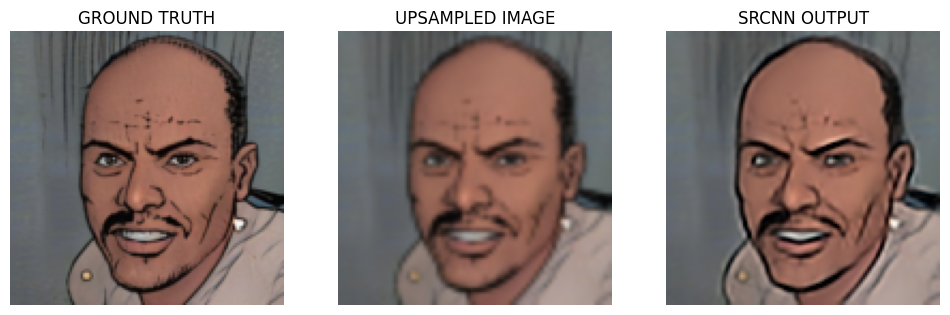

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38360965..1.151794].


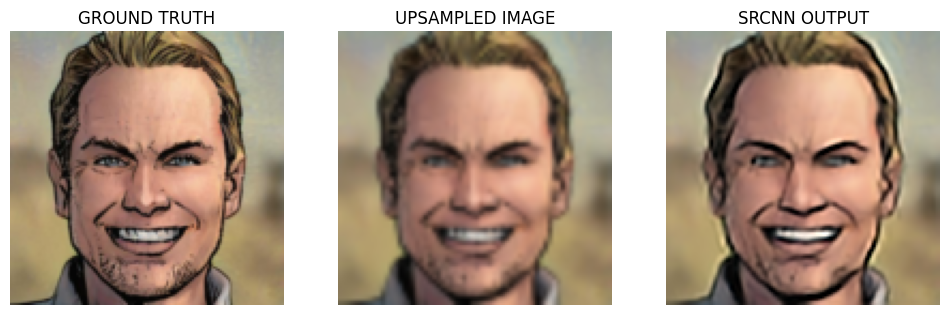

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30524468..1.0730493].


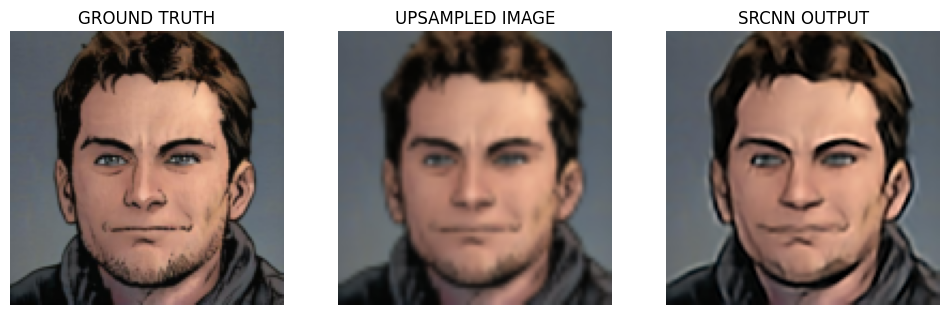

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.28957093..1.1310704].


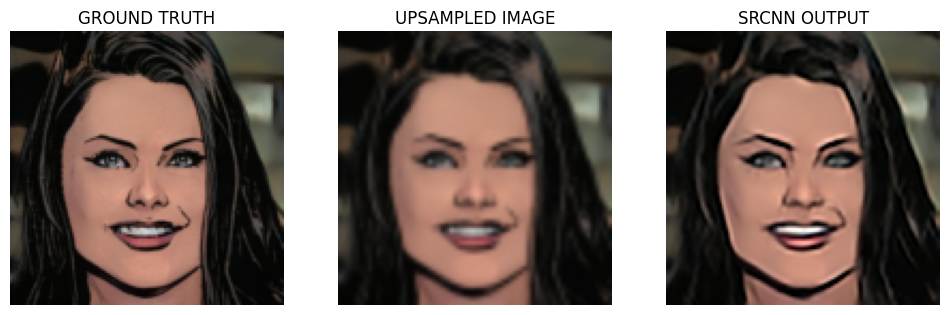

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.37201408..1.1223555].


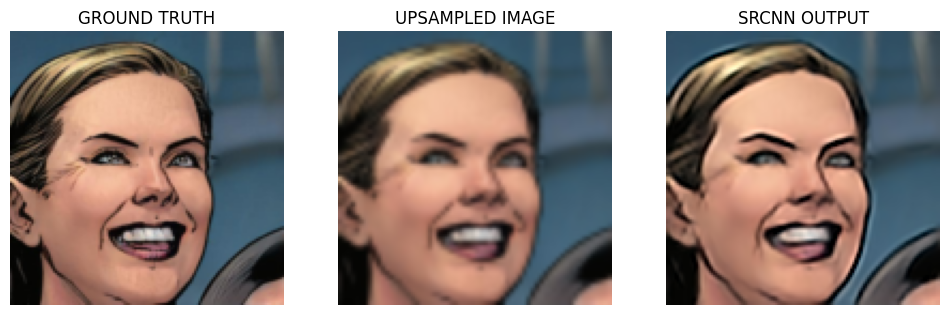

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4657777..1.1679897].


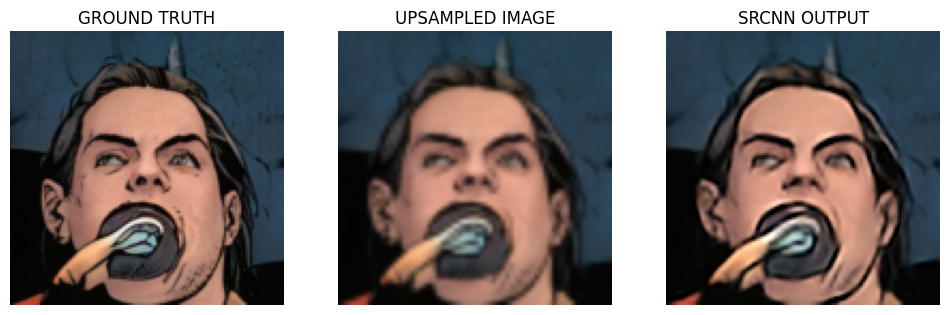

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1845173..0.96792156].


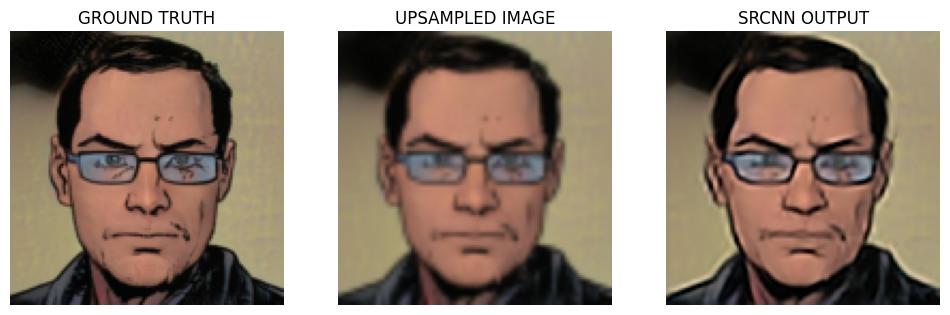

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.28504118..1.1395425].


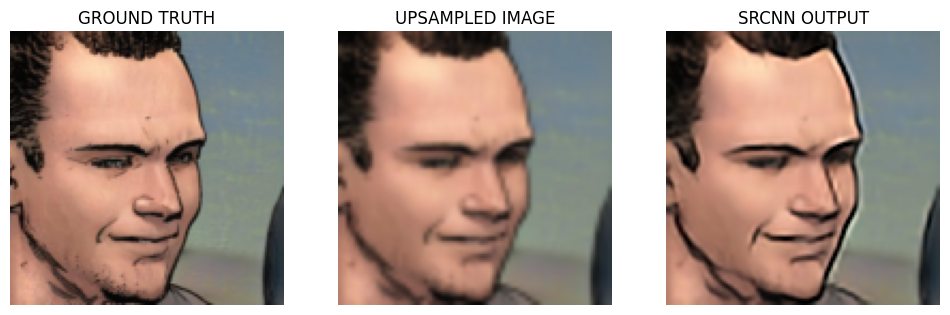

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.23483193..1.0782828].


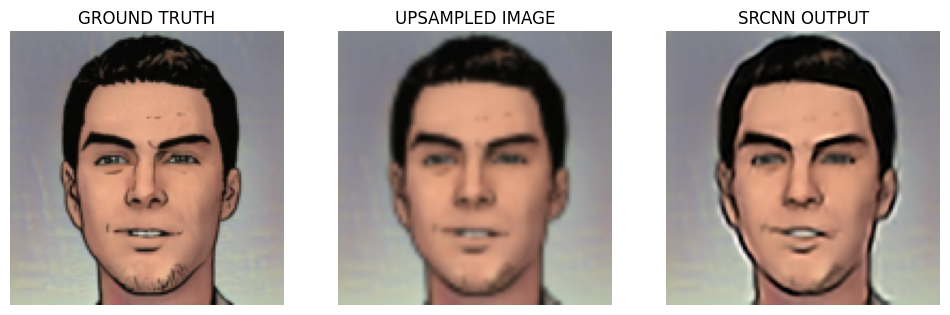

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2913401..1.159136].


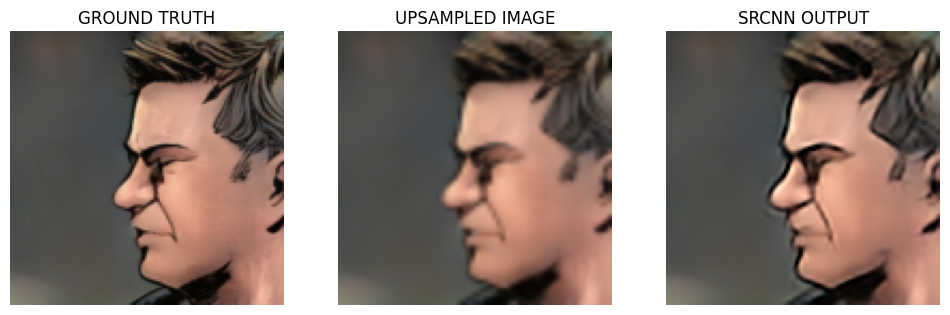

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.25901026..1.361376].


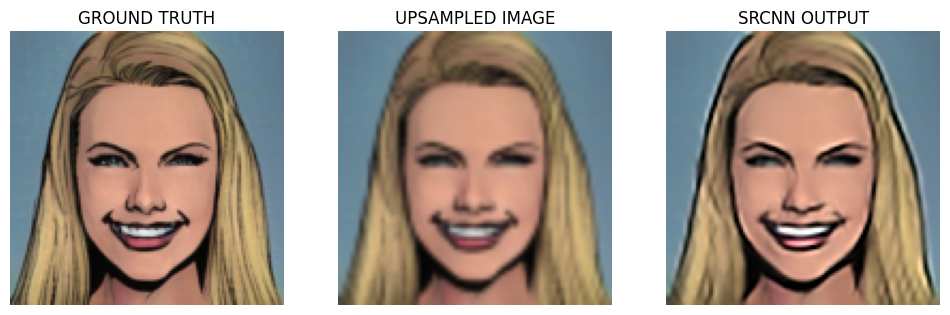

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20307215..1.0041225].


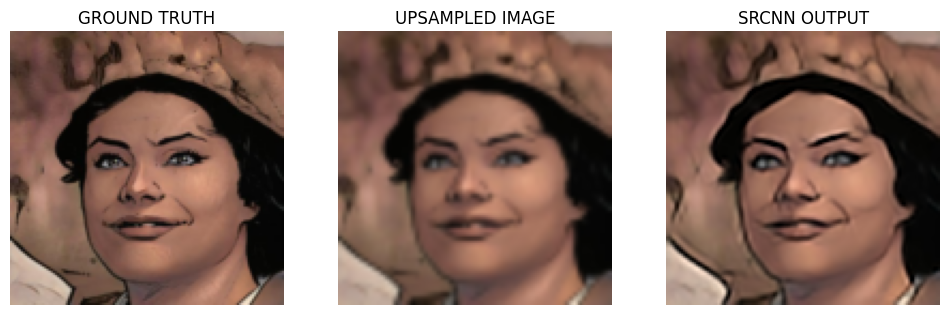

In [ ]:
def test_model():
    model.eval()
    with torch.no_grad():

        for i, data in enumerate(test_loader):
            if i >= 20:
                break
            inputs = data.to(device)
            inputs_downsampled = F.interpolate(inputs, scale_factor=scale_factor , mode='bilinear', align_corners=False)
            inputs_upsampled = F.interpolate(inputs_downsampled, size=inputs.shape[2:], mode='bilinear', align_corners=False)
            outputs = model(inputs_upsampled)

            outputs = F.interpolate(outputs, size=inputs.shape[2:], mode='bicubic', align_corners=False)

            visualize_images(inputs[0], inputs_upsampled[0], outputs[0])

test_model()